In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision.utils as vutils
import matplotlib.pyplot as plt
from tqdm import tqdm
from inception_score import inception_score # from folder

# Set random seed for reproducibility
torch.manual_seed(42)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.backends.mps.is_available():
    device = torch.device("mps")
print("Device:", device)

# Define the generator and discriminator architectures
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )
        print("Ended Generator Code")

    def forward(self, input):
        return self.model(input)


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 128, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
        print("Ended Discriminator Code")

    def forward(self, input):
        return self.model(input)


# Initialize the generator and discriminator
generator = Generator()
discriminator = Discriminator()

# Define the loss function and optimizers
criterion = nn.BCELoss().to(device)
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Set up DataLoader for CIFAR-10 dataset
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

batch_size = 64
dataset = datasets.CIFAR10(root='./data', download=True, train=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

# Training the DCGAN
num_epochs = 1
generator.to(device)
discriminator.to(device)

for epoch in tqdm(range(num_epochs)):
    for i, data in enumerate(dataloader, 0):
        # Update discriminator with real data
        discriminator.zero_grad()
        real_images, _ = data
        real_images = real_images.to(device)
        batch_size_curr = real_images.size(0)  # Get the current batch size
        label = torch.full((batch_size_curr, 1, 1, 1), 1.0, device=device)
        output = discriminator(real_images)
        # errD_real = criterion(output, label)
        errD_real = criterion(output, label.expand_as(output))
        errD_real.backward()
        D_x = output.mean().item()
        print("Worked real output", i , "Times")

        
        # label = torch.full((batch_size, 1, 1, 1), 1.0, device=device)
        # output = discriminator(real_images)
        # print("Worked real output", i , "Times")
        # # errD_real = criterion(output.view(-1), label)
        # # errD_real = criterion(output.squeeze(), label)
        # # errD_real = criterion(output, label)
        # errD_real = criterion(output, label.expand_as(output))
        # errD_real.backward()
        # # print("Worked errD_real.backward")
        # D_x = output.mean().item()

                # # Update discriminator with fake data
                # noise = torch.randn(batch_size, 100, 1, 1, device=device)
                # fake_images = generator(noise)
                # label.fill_(0.0)
                # output = discriminator(fake_images.detach())
                # # errD_fake = criterion(output, label)
                # errD_fake = criterion(output, label.expand_as(output))
                # errD_fake.backward()
                # D_G_z1 = output.mean().item()
                # errD = errD_real + errD_fake
                # optimizer_D.step()
        
        # Update discriminator with fake data
        noise = torch.randn(batch_size_curr, 100, 1, 1, device=device)  # Use batch_size_curr instead of batch_size
        fake_images = generator(noise)
        label.fill_(0.0)
        output = discriminator(fake_images.detach())
        errD_fake = criterion(output, label.expand_as(output))
        print("errD_fake Criterion worked ", i , "times")
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizer_D.step()


        # output = discriminator(fake_images.detach())
        # # print("Worked Fake output")
        # errD_fake = criterion(output, label.expand_as(output))
        # errD_fake.backward()
        # # print("Worked errD_fake.backward")
        # D_G_z1 = output.mean().item()
        # errD = errD_real + errD_fake
        # optimizer_D.step()

        # Update generator
        generator.zero_grad()
        label.fill_(1.0)
        output = discriminator(fake_images)
        # print("Discriminator: ")
        # errG = criterion(output.view(-1), label)
        errG = criterion(output, label.expand_as(output))
        # print("errG:")
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizer_G.step()
print("Train loop ended")       
# Save the generator model
torch.save(generator.state_dict(), 'generator.pth')


Device: mps
Ended Generator Code
Ended Discriminator Code
Files already downloaded and verified


  0%|          | 0/1 [00:00<?, ?it/s]

Worked real output 0 Times
errD_fake Criterion worked  0 times
Worked real output 1 Times
errD_fake Criterion worked  1 times
Worked real output 2 Times
errD_fake Criterion worked  2 times
Worked real output 3 Times
errD_fake Criterion worked  3 times
Worked real output 4 Times
errD_fake Criterion worked  4 times
Worked real output 5 Times
errD_fake Criterion worked  5 times
Worked real output 6 Times
errD_fake Criterion worked  6 times
Worked real output 7 Times
errD_fake Criterion worked  7 times
Worked real output 8 Times
errD_fake Criterion worked  8 times
Worked real output 9 Times
errD_fake Criterion worked  9 times
Worked real output 10 Times
errD_fake Criterion worked  10 times
Worked real output 11 Times
errD_fake Criterion worked  11 times
Worked real output 12 Times
errD_fake Criterion worked  12 times
Worked real output 13 Times
errD_fake Criterion worked  13 times
Worked real output 14 Times
errD_fake Criterion worked  14 times
Worked real output 15 Times
errD_fake Criteri

100%|██████████| 1/1 [06:40<00:00, 400.02s/it]

Train loop ended


In [4]:
import numpy as np
# Generate 10 images from the learned distribution and save them
generator.eval()
for i in range(10):
    noise = torch.randn(1, 100, 1, 1, device=device)
    fake_image = generator(noise).detach().cpu().squeeze().numpy()
    fake_image = (fake_image + 1) / 2.0  # Rescale values to [0, 1]
    plt.imsave(f'generated_image_{i+1}.png', np.transpose(fake_image, (1, 2, 0)))


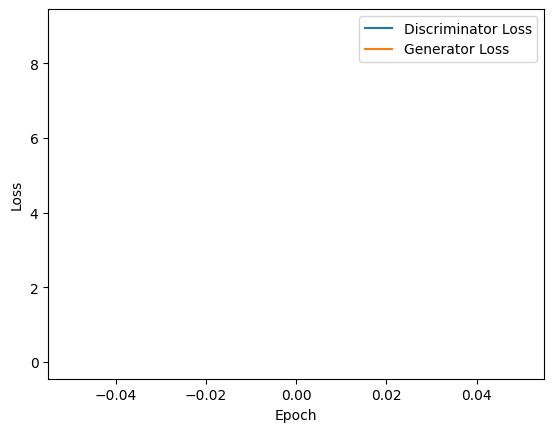

In [7]:

# Plot the Loss vs Epoch curve
plt.plot(range(num_epochs), errD.item(), label="Discriminator Loss")
plt.plot(range(num_epochs), errG.item(), label="Generator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [12]:
# Calculate Inception Score on the generated images
fake_images_list = []
for i in range(500):  # Generate 500 images for a more accurate Inception Score
    noise = torch.randn(1, 100, 1, 1, device=device)
    fake_images_list.append(generator(noise).detach().cpu())
fake_images_tensor = torch.cat(fake_images_list, dim=0)
inception_mean, inception_std = inception_score(fake_images_tensor, 
                                                cuda=False, #cuda=True, 
                                                batch_size=32, resize=True, splits=1)

print(f"Inception Score: {inception_mean} ± {inception_std}")

/opt/homebrew/Caskroom/miniforge/base/envs/venv1/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/venv1/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/Users/hrithik/Library/Mobile Documents/com~apple~CloudDocs/iCloud Downloads/IIITH PGSSP/Assignments/DLTP/DLTP-M23-IIITH-Assignment-4/inception_score.py:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.soft

Inception Score: 1.1946327017802276 ± 0.0


Inception Score for 1 epoch = 1.1946327017802276 ± 0.0